# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas as pd
import geopandas as gpd
import datetime
pd.options.display.max_columns = None

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

watershed_workflow.ui.setup_logging(1, None)
figsize = (6,6)
figsize_3d = (8,6)


In [4]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [5]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Coweeta' # name the domain, used in filenames, etc
coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2010,8,1)
end = datetime.date(2011,8,1)
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
coweeta = watershed_workflow.getShapes(coweeta_shapefile)
coweeta.rename(columns={'AREA' : names.AREA, 'LABEL' : names.NAME}, inplace=True)
coweeta[names.ID] = coweeta.index.values
coweeta.set_index(names.ID, inplace=True, drop=True)

2025-07-28 09:40:20,819 - root - INFO: 
2025-07-28 09:40:20,820 - root - INFO: Meshing shape: Coweeta/input_data/coweeta_basin.shp
2025-07-28 09:40:20,820 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [6]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [7]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = coweeta.crs


In [8]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus HR']
sources['HUC'] = watershed_workflow.source_list.huc_sources['WaterData WBD']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
lc_file = ['input_data', 'land_cover', 'land_cover.tif']
dtb_file = ['input_data', 'DTB', 'DTB.tif']
geo_file = ['input_data', 'GLHYMPS', 'GLHYMPS.shp']
if os.path.split(os.getcwd())[-1] == 'examples':
    lc_file.insert(0, 'Coweeta')
    dtb_file.insert(0, 'Coweeta')
    geo_file.insert(0, 'Coweeta')

sources['land cover'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*lc_file))
sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS(os.path.join(*geo_file))

#
# the Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.  Here we will use a clipped version of that map
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*dtb_file))
watershed_workflow.source_list.logSources(sources)

2025-07-28 09:40:20,897 - root - INFO: Using sources:
2025-07-28 09:40:20,897 - root - INFO: --------------
2025-07-28 09:40:20,898 - root - INFO: HUC: WaterData
2025-07-28 09:40:20,898 - root - INFO: hydrography: NHDPlusHR
2025-07-28 09:40:20,898 - root - INFO: DEM: 3DEP
2025-07-28 09:40:20,899 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-07-28 09:40:20,899 - root - INFO: geologic structure: Coweeta/input_data/GLHYMPS/GLHYMPS.shp
2025-07-28 09:40:20,899 - root - INFO: land cover: raster
2025-07-28 09:40:20,900 - root - INFO: LAI: MODIS
2025-07-28 09:40:20,900 - root - INFO: depth to bedrock: raster
2025-07-28 09:40:20,901 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

2025-07-28 09:40:58,542 - root - INFO: Removing holes on 1 polygons
2025-07-28 09:40:58,543 - root - INFO:   -- removed interior
2025-07-28 09:40:58,543 - root - INFO:   -- union
2025-07-28 09:40:58,544 - root - INFO: Parsing 1 components for holes
2025-07-28 09:40:58,544 - root - INFO:   -- complete


<Axes: >

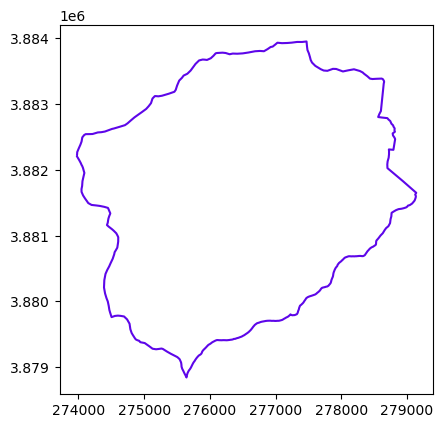

In [9]:
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

In [10]:
include_rivers = True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
    rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers



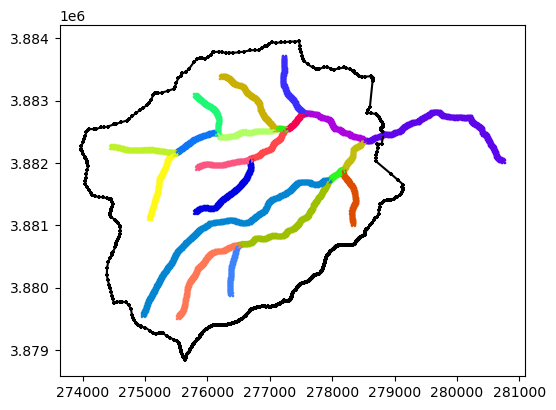

In [11]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [12]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

2025-07-28 09:41:00,325 - root - INFO: 
2025-07-28 09:41:00,325 - root - INFO: Simplifying
2025-07-28 09:41:00,326 - root - INFO: ------------------------------
2025-07-28 09:41:00,326 - root - INFO: EPSG:26917
2025-07-28 09:41:00,326 - root - INFO: Presimplify to remove colinear, coincident points.
2025-07-28 09:41:00,330 - root - INFO: EPSG:26917
2025-07-28 09:41:00,330 - root - INFO: Pruning leaf reaches < 75
2025-07-28 09:41:00,331 - root - INFO: EPSG:26917
2025-07-28 09:41:00,331 - root - INFO: Merging internal reaches < 75
2025-07-28 09:41:00,331 - root - INFO: EPSG:26917


2025-07-28 09:41:00,333 - root - INFO:   reach: min seg length: 	    4.7587576154 	min geom length: 	  166.3875502634
2025-07-28 09:41:00,333 - root - INFO:   reach: med seg length: 	    5.7330762967 	med geom length: 	  993.9415838142
2025-07-28 09:41:00,333 - root - INFO:   reach: max seg length: 	   28.6414776520 	max geom length: 	 4073.8784132946
2025-07-28 09:41:00,334 - root - INFO: 
2025-07-28 09:41:00,334 - root - INFO:   HUC  : min seg length: 	    6.0465606669 	min geom length: 	17521.7680419622
2025-07-28 09:41:00,335 - root - INFO:   HUC  : med seg length: 	   20.1713567722 	med geom length: 	17521.7680419622
2025-07-28 09:41:00,335 - root - INFO:   HUC  : max seg length: 	  420.9046644215 	max geom length: 	17521.7680419622
2025-07-28 09:41:00,335 - root - INFO: 
2025-07-28 09:41:00,335 - root - INFO: Snapping discrete points to make rivers and HUCs discretely consistent.
2025-07-28 09:41:00,335 - root - INFO:  -- snapping HUC triple junctions to reaches
2025-07-28 09:41:

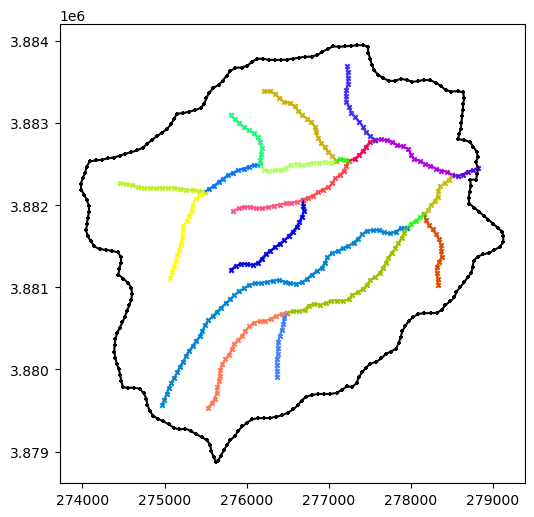

In [13]:
plot(watershed, rivers)

In [14]:
rivers[0].df.index

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20],
      dtype='int64', name='new_preorder_index')

In [15]:
rivers[0].df.index.name

'new_preorder_index'

In [16]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
# m = watershed_workflow.makeMap(m)
m

2025-07-28 09:41:06,859 - root - INFO: 
2025-07-28 09:41:06,859 - root - INFO: Triangulation
2025-07-28 09:41:06,860 - root - INFO: ------------------------------
2025-07-28 09:41:06,873 - root - INFO: Triangulating...
2025-07-28 09:41:06,874 - root - INFO:    234 points and 234 facets
2025-07-28 09:41:06,875 - root - INFO:  checking graph consistency
2025-07-28 09:41:06,875 - root - INFO:  tolerance is set to 1.0
2025-07-28 09:41:06,876 - root - INFO:  building graph data structures
2025-07-28 09:41:06,877 - root - INFO:  triangle.build...
2025-07-28 09:42:41,593 - root - INFO:   ...built: 8146 mesh points and 16056 triangles
2025-07-28 09:42:41,593 - root - INFO: Plotting triangulation diagnostics
2025-07-28 09:42:42,004 - root - INFO:   min area = 295.57635498046875
2025-07-28 09:42:42,004 - root - INFO:   max area = 4908.594055175781


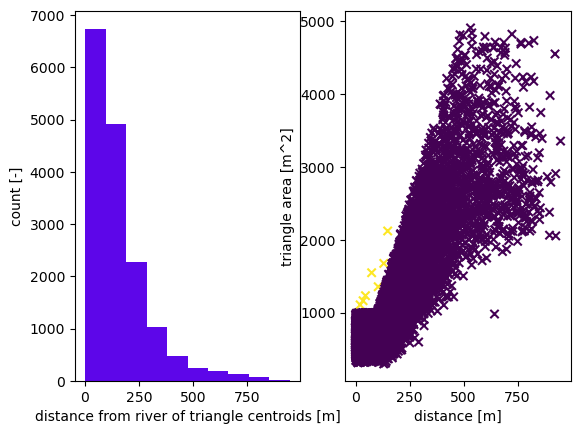

In [17]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000


# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
m2, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [18]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# elevate the triangle nodes to the dem
watershed_workflow.elevate(m2, dem)

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

2025-07-28 09:42:44,417 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


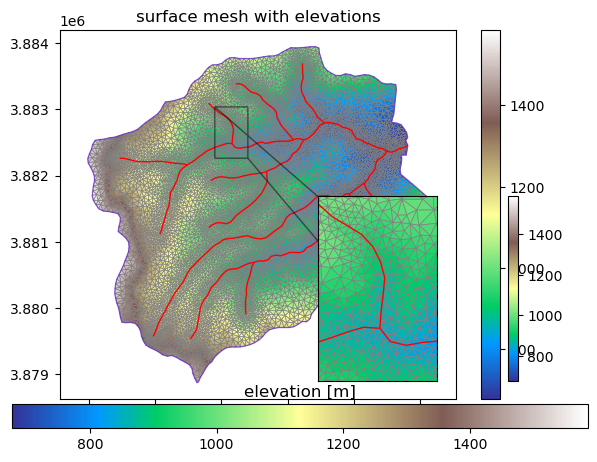

In [19]:
# plot the resulting surface mesh
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, cmap='terrain', norm=norm)
watershed.plot(ax=ax, alpha=0.5, linewidth=1)
rivers[0].plot(ax=ax, color='red', linewidth=1)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2, cmap='terrain', norm=norm)
rivers[0].plot(ax=ax2, color='red', linewidth=1)
ax2.set_aspect('equal', 'datalim')

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()

In [20]:
import copy
m2_before_conditioning = copy.deepcopy(m2)

In [21]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fillPitsDual(m2)


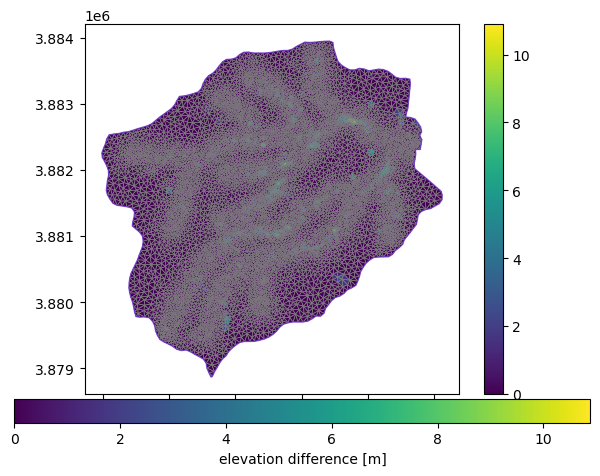

In [22]:
m2_diff = copy.deepcopy(m2)
m2_diff.coords[:,2] = m2.coords[:,2] - m2_before_conditioning.coords[:,2]

# plot the resulting surface mesh
fig, ax = plt.subplots()

# plot the mesh with elevation differences
mp = m2_diff.plot(facecolors='elevation', ax=ax, cmap='viridis')
watershed.plot(ax=ax, alpha=0.5, linewidth=1)

# add colorbar with explicit axes
cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
cbar.set_label('elevation difference [m]')

plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [23]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs, band=1)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-07-28 09:44:48,788 - root - INFO: Found land cover dtypes: uint8
2025-07-28 09:44:48,791 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(82), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(90)}


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (0.66666666667, 0.43921568628, 0.1568627451), (0.72941176471, 0.84705882353, 0.91764705882)]


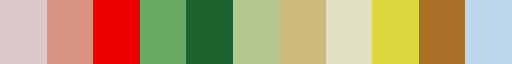

In [24]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

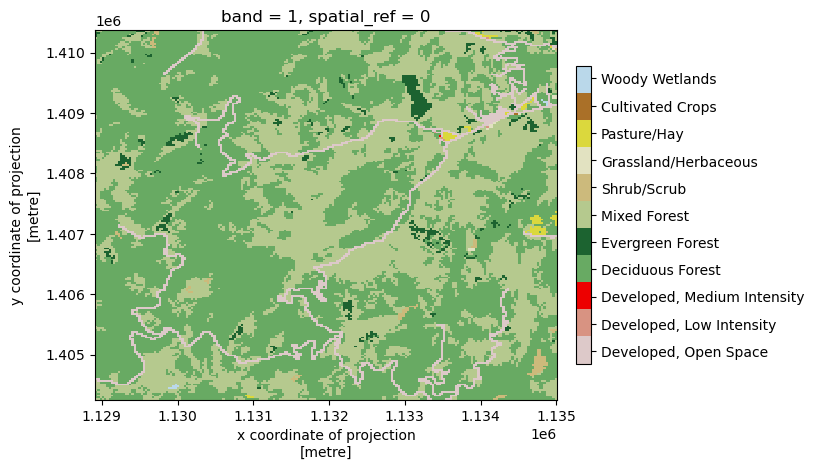

In [25]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
plt.show()

In [26]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})

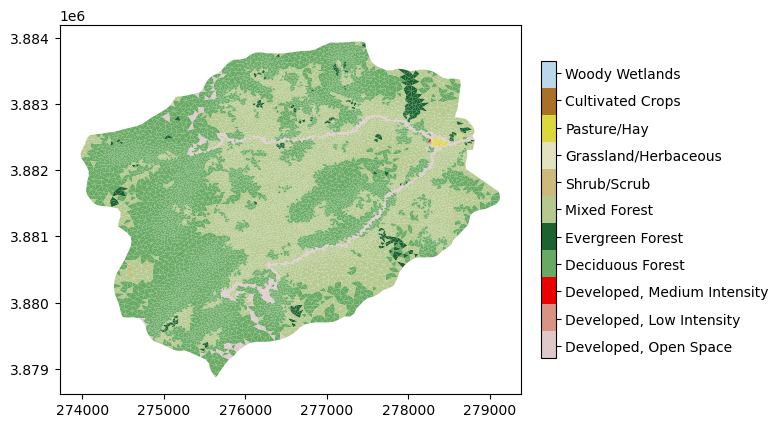

In [27]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [28]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [29]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

21 : CELL : 672 : "Developed, Open Space"
22 : CELL : 1 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 7857 : "Deciduous Forest"
42 : CELL : 287 : "Evergreen Forest"
43 : CELL : 7199 : "Mixed Forest"
52 : CELL : 5 : "Shrub/Scrub"
81 : CELL : 33 : "Pasture/Hay"


## MODIS LAI

In [30]:
startdate = start #f'{start_year}-01-01'
enddate = end #f'{end_year+1}-01-01'
res = sources['LAI'].getDataset(watershed.exterior.bounds, crs, startdate, enddate)


2025-07-28 09:45:34,911 - root - INFO: ... searching for: /Users/7s2/Research/watershed_workflow_data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2011_35.0841x-83.4888_35.0172x-83.4111.nc
2025-07-28 09:45:34,911 - root - INFO: ... searching for: /Users/7s2/Research/watershed_workflow_data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2011_35.0841x-83.4888_35.0172x-83.4111.nc


In [31]:
if isinstance(res, watershed_workflow.sources.manager_modis_appeears.Task):
    assert sources['LAI'].is_ready(res)
    modis_data = sources['LAI'].getDataset(task=res)
else:
    modis_data = res

assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float32


In [32]:
# remove leap day (366th day of any leap year)
for k,v in modis_data.items():
    assert v.rio.crs is not None
    new_v = watershed_workflow.data.filterLeapDay(v)
    assert new_v.rio.crs is not None
    modis_data[k] = new_v


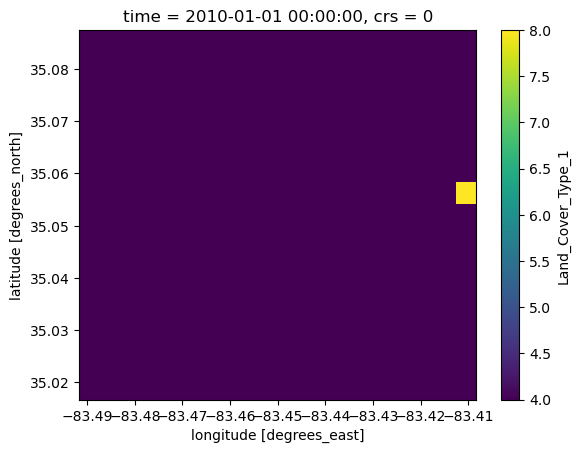

In [33]:
modis_data['LULC'][0].plot.imshow()

In [34]:
# need new start and end dates in the new calendar
startdate = start 
enddate = end 

# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [35]:
lai_df

,time [datetime],Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.100000
1,2010-08-05 00:00:00,4.576842
2,2010-08-09 00:00:00,3.388421
3,2010-08-13 00:00:00,4.207368
4,2010-08-17 00:00:00,3.181053
...,...,...
88,2011-07-16 00:00:00,6.172632
89,2011-07-20 00:00:00,4.505263
90,2011-07-24 00:00:00,4.624211
91,2011-07-28 00:00:00,5.363158


2025-07-28 09:45:37,690 - root - INFO: Writing HDF5 file: Coweeta_LAI_MODIS_Dynamic.h5


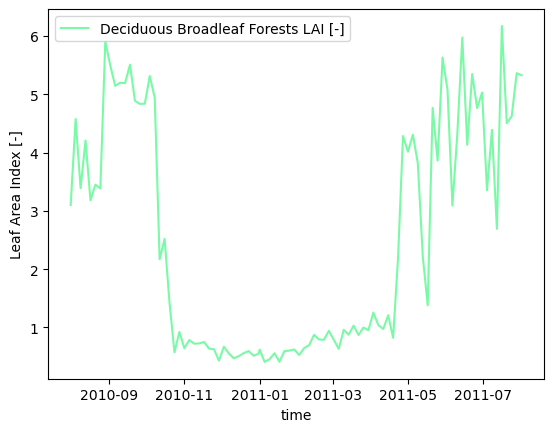

In [36]:
watershed_workflow.io.writeTimeseriesToHDF5('Coweeta_LAI_MODIS_Dynamic.h5', lai_df)
watershed_workflow.land_cover_properties.plotLAI(lai_df, indices='MODIS')

2025-07-28 09:45:38,177 - root - INFO: Writing HDF5 file: Coweeta_LAI_MODIS_CyclicSteadystate.h5


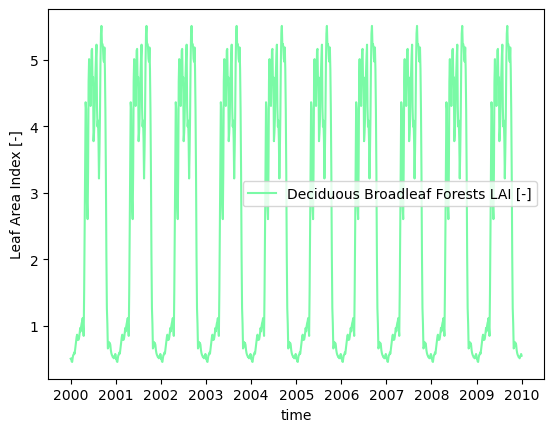

In [37]:
lai_smoothed = watershed_workflow.data.smoothTimeSeries(lai_df, 'time [datetime]')
lai_typical_df = watershed_workflow.data.computeAverageYear(lai_smoothed, 'time [datetime]', output_nyears=10, 
                                                                  start_year=2000)

watershed_workflow.io.writeTimeseriesToHDF5('Coweeta_LAI_MODIS_CyclicSteadystate.h5', lai_typical_df)
watershed_workflow.land_cover_properties.plotLAI(lai_typical_df, indices='MODIS')

## Crosswalk of LAI to NLCD LC

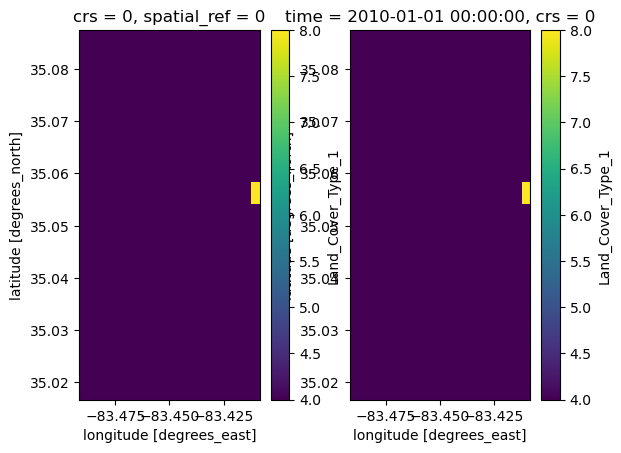

In [38]:
modis_lulc_mode = watershed_workflow.data.computeMode(modis_data['LULC'])

fig, ax = plt.subplots(1,2)
modis_lulc_mode.plot.imshow(ax=ax[0])
modis_data['LULC'][0].plot.imshow(ax=ax[1])
plt.show()

In [39]:
print(watershed_workflow.crs.from_xarray(modis_data['LULC']))
print(watershed_workflow.crs.from_xarray(modis_lulc_mode))

EPSG:4269
EPSG:4269


2025-07-28 09:45:40,718 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-07-28 09:45:40,718 - root - INFO:   unique MODIS: [np.float64(4.0)]
2025-07-28 09:45:40,718 - root - INFO:   unique NLCD: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90)]


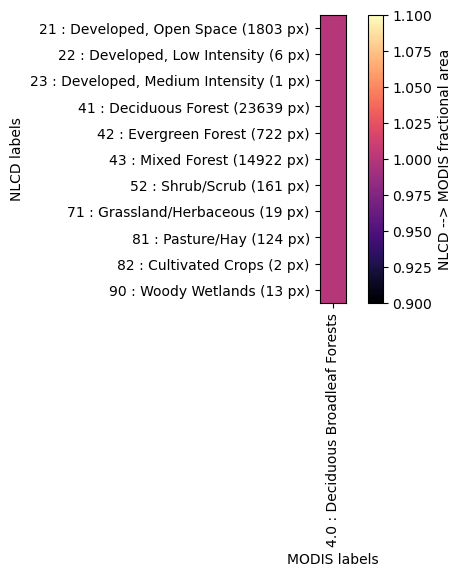

In [40]:
cw = watershed_workflow.land_cover_properties.computeCrosswalk(modis_lulc_mode, nlcd, method='fractional area')

In [41]:
# Compute the NLCD-based time series
nlcd_lai = watershed_workflow.land_cover_properties.applyCrosswalk(cw, lai_typical_df)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai)
nlcd_lai

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time [datetime],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-],Cultivated Crops LAI [-],Woody Wetlands LAI [-]
0,2000-01-01 00:00:00,0.509323,0.509323,0.0,0.509323,0.509323,0.509323,0.509323,0.509323,0.509323,0.509323,0.509323
1,2000-01-05 00:00:00,0.513885,0.513885,0.0,0.513885,0.513885,0.513885,0.513885,0.513885,0.513885,0.513885,0.513885
2,2000-01-09 00:00:00,0.467168,0.467168,0.0,0.467168,0.467168,0.467168,0.467168,0.467168,0.467168,0.467168,0.467168
3,2000-01-13 00:00:00,0.460952,0.460952,0.0,0.460952,0.460952,0.460952,0.460952,0.460952,0.460952,0.460952,0.460952
4,2000-01-17 00:00:00,0.519850,0.519850,0.0,0.519850,0.519850,0.519850,0.519850,0.519850,0.519850,0.519850,0.519850
...,...,...,...,...,...,...,...,...,...,...,...,...
915,2009-12-15 00:00:00,0.515338,0.515338,0.0,0.515338,0.515338,0.515338,0.515338,0.515338,0.515338,0.515338,0.515338
916,2009-12-19 00:00:00,0.537694,0.537694,0.0,0.537694,0.537694,0.537694,0.537694,0.537694,0.537694,0.537694,0.537694
917,2009-12-23 00:00:00,0.552882,0.552882,0.0,0.552882,0.552882,0.552882,0.552882,0.552882,0.552882,0.552882,0.552882
918,2009-12-27 00:00:00,0.580251,0.580251,0.0,0.580251,0.580251,0.580251,0.580251,0.580251,0.580251,0.580251,0.580251


# Subsurface Soil, Geologic Structure

## NRCS Soils

In [47]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs).to_crs(crs)


2025-07-28 09:47:05,192 - root - INFO: Attempting to download source for target '/Users/7s2/Research/watershed_workflow_data/soil_structure/SSURGO/SSURGO_-83.4785_35.0275_-83.4217_35.0739.shp'
2025-07-28 09:47:05,196 - root - INFO:   Found 459 shapes.
2025-07-28 09:47:05,247 - root - INFO: found 41 unique MUKEYs.
2025-07-28 09:47:05,534 - root - INFO: Running Rosetta for van Genutchen parameters
2025-07-28 09:47:05,578 - root - INFO:   ... done
2025-07-28 09:47:05,579 - root - INFO:   requested 41 values
2025-07-28 09:47:05,579 - root - INFO:   got 41 responses


In [48]:
nrcs

,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID
0,545800,"MULTIPOLYGON (((275540.857 3878889.162, 275543...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800
1,545801,"MULTIPOLYGON (((274079.22 3881405.531, 274059....",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801
2,545803,"MULTIPOLYGON (((275544.375 3882460.138, 275520...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803
3,545805,"MULTIPOLYGON (((278552.055 3878816.23, 278544....",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805
4,545806,"MULTIPOLYGON (((278524.206 3878902.488, 278518...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806
5,545807,"MULTIPOLYGON (((275546.72 3879760.306, 275583....",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807
6,545811,"MULTIPOLYGON (((274268.333 3879023.972, 274261...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811
7,545812,"POLYGON ((274253.1 3878981.163, 274235.982 387...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812
8,545813,"MULTIPOLYGON (((277041.095 3878844.7, 277047.1...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813
9,545814,"MULTIPOLYGON (((278884.395 3878813.09, 278891....",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814


In [49]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
dtype: bool

In [50]:
# Compute the soil color of each cell of the mesh
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'ID', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('ID', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.ID, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


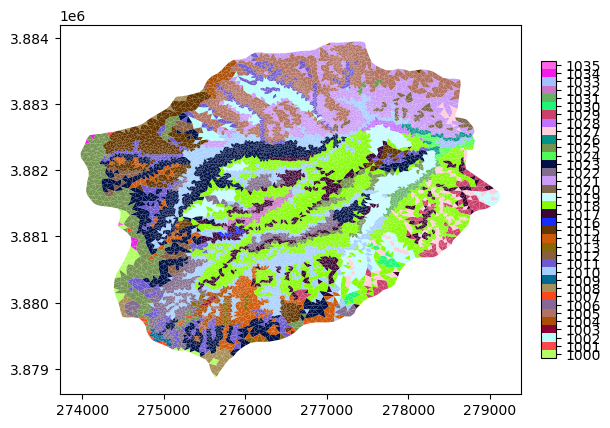

In [51]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from SoilGrids

In [52]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

In [53]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


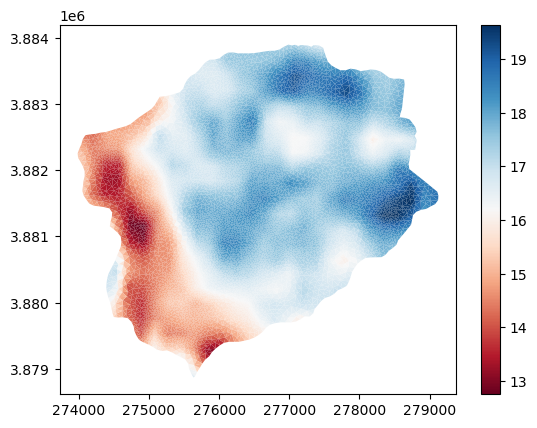

In [54]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [55]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, 
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# convert to the right geometry (this should be done in a call to ww.getShapesByGeometry()!
glhymps = glhymps.to_crs(watershed.crs)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

,id,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,
1,1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((199946.461 3861121.027, 199873..."


In [56]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,id,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,
1,1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((199946.461 3861121.027, 199873..."


In [57]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

id                             False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [58]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,id,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1,)",1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((199946.461 3861121.027, 199873..."


In [59]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [60]:
geology_color_glhymps.min()

np.int64(0)

## Combine to form a complete subsurface dataset

In [61]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = os.path.join(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(outputs['subsurface_properties_filename'])
subsurface_props


,ID,id,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1,)",1793338.0,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((199946.461 3861121.027, 199873...",NaN,NaN
1000,545800,NaN,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((275540.857 3878889.162, 275543...",545800.0,2.03
1001,545801,NaN,NRCS,3.247236e-15,0.303714,0.000139,1.469513,0.177493,"MULTIPOLYGON (((274079.22 3881405.531, 274059....",545801.0,2.03
1002,545803,NaN,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((275544.375 3882460.138, 275520...",545803.0,2.03
1003,545805,NaN,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((278552.055 3878816.23, 278544....",545805.0,2.03
1004,545806,NaN,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((278524.206 3878902.488, 278518...",545806.0,2.03
1005,545807,NaN,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((275546.72 3879760.306, 275583....",545807.0,2.03
1006,545811,NaN,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((274268.333 3879023.972, 274261...",545811.0,2.03
1007,545813,NaN,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((277041.095 3878844.7, 277047.1...",545813.0,2.03
1008,545814,NaN,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((278884.395 3878813.09, 278891....",545814.0,2.03


# Extrude the 2D Mesh to make a 3D mesh

In [63]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.

total thickness: 19.65010231045368 m


In [64]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05252036 0.06479527 0.09181838 0.14694819 0.25946146 0.39251928
 0.49439017 0.49754689]
2.0


In [65]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [66]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[ 2.71470626  5.85798457  9.42730917 10.         10.         10.        ]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [67]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
len(subsurface_props_used)


2025-07-28 09:48:21,054 - root - INFO: Cell summary:
2025-07-28 09:48:21,055 - root - INFO: ------------------------------------------------------------
2025-07-28 09:48:21,055 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-07-28 09:48:21,055 - root - INFO: ------------------------------------------------------------
2025-07-28 09:48:21,056 - root - INFO:  00 	| 00 	| 1008 	|   0.050000 	|   0.000000
2025-07-28 09:48:21,056 - root - INFO:  01 	| 01 	| 1008 	|   0.050000 	|   0.050000
2025-07-28 09:48:21,056 - root - INFO:  02 	| 02 	| 1008 	|   0.050000 	|   0.100000
2025-07-28 09:48:21,056 - root - INFO:  03 	| 03 	| 1008 	|   0.120000 	|   0.150000
2025-07-28 09:48:21,056 - root - INFO:  04 	| 04 	| 1008 	|   0.230000 	|   0.270000
2025-07-28 09:48:21,056 - root - INFO:  05 	| 05 	| 1008 	|   0.500000 	|   0.500000
2025-07-28 09:48:21,057 - root - INFO:  06 	| 06 	| 1008 	|   0.500000 	|   1.000000
2025-07-28 09:48:21,057 - root - INFO:  07 	| 07 	| 1008 	|   0.500000 	|   1.5

38

In [68]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [69]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
21 : CELL : 672 : "Developed, Open Space"
22 : CELL : 1 : "Developed, Low Intensity"
23 : CELL : 2 : "Developed, Medium Intensity"
41 : CELL : 7857 : "Deciduous Forest"
42 : CELL : 287 : "Evergreen Forest"
43 : CELL : 7199 : "Mixed Forest"
52 : CELL : 5 : "Shrub/Scrub"
81 : CELL : 33 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------

Extruded 3D side sets
---------------------
1 : FACE : 16056 : "bottom"
2 : FACE : 16056 : "surface"
3 : FACE : 3510 : "external_sides"
21 : FACE : 672 : "Developed, Open Space"
22 : FACE : 1 : "Developed, Low Intensity"
23 : FACE : 2 : "Developed, Medium Intensity"
41 : FACE : 7857 : "Deciduous Forest"
42 : FACE : 287 : "Evergreen Forest"
43 : FACE : 7199 : "Mixed Forest"
52 : FACE : 5 : "Shrub/Scrub"
81 : FACE : 33 : "Pasture/Hay"


In [70]:
# save the mesh to disk
outputs['mesh_filename'] = os.path.join('output_data',f'{name}.exo')
try:
    os.remove(outputs['mesh_filename'])
except FileNotFoundError:
    pass
# m3.writeExodus(outputs['mesh_filename'])